In [20]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

In [21]:
X = datasets.fetch_covtype().data[:3000]
y = datasets.fetch_covtype().target[:3000]
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_va, y_train, y_va = train_test_split(X_1, y_1)

print(X_train.shape, y_train.shape)
print(np.unique(y_train))  # 7分类任务

(2025, 54) (2025,)
[1 2 3 4 5 6 7]


In [22]:
enc = OrdinalEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
y_va_enc = enc.fit_transform(y_va.reshape(-1, 1))
print(np.unique(y_train_enc))
print(y_train_enc.shape)

[0. 1. 2. 3. 4. 5. 6.]
(2025, 1)


In [23]:
# label.shape = (num_sample, )
train_dataset = lgb.Dataset(data=X_train, label=y_train_enc.reshape(-1, ))
val_dataset = lgb.Dataset(data=X_va, label=y_va_enc.reshape(-1, ))

In [24]:
from sklearn.metrics import log_loss


def my_gbm_loss(y_pred, y_true):
    """lightgbm自定义验证数据集损失函数格式"""
    # 多分类任务中,y_pred先按类进行分组(比如前7个值是y_true[0]的预测值,最后7个值是y_true[-1]的预测值)
    reshape_y_pred = np.transpose(y_pred.reshape(7, -1))  # 这是一个7分类任务
    loss = log_loss(y_true.get_label(), reshape_y_pred)
    # print("y_true.shape:{0},y_pred.shape:{1},reshape_y_pred.shape:{2}".format(y_true.get_label().shape, y_pred.shape, reshape_y_pred.shape))
    # 返回值格式:评估函数的名称(不含空格), 评估结果, 评估结果是否越高越高(比如AUC是越高越好,损失值是越低越好)
    return 'MY_GBM_LOSS', loss, False

In [25]:
params = {"objective": "multiclass",
          "num_class": 7,
          "verbose": -4, "metric": ("multi_logloss",)}

eval_set = [train_dataset, val_dataset]
evals_result = {}  # 储存评估指标(内置和自定义)结果

model = lgb.train(params=params,
                  train_set=train_dataset,
                  early_stopping_rounds=20,  # 默认early_stopping_rounds=None
                  # List of data to be evaluated on during training.
                  valid_sets=eval_set,
                  # This dictionary used to store all evaluation results of all the items in valid_sets.
                  evals_result=evals_result,
                  num_boost_round=200,  # 默认num_boost_round=1000
                  # Requires at least one validation data.
                  # If True, the eval metric on the valid set is printed at each boosting stage.
                  # If int, the eval metric on the valid set is printed at every verbose_eval boosting stage.
                  # The last boosting stage or the boosting stage found by using early_stopping_rounds is also printed.
                  verbose_eval=200,  # 默认verbose_eval=True
                  feval=my_gbm_loss)  # Customized evaluation function

# 预测结果为概率向量(多分类)
# X_test: numpy array, pandas DataFrame
model.predict(X_test)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	training's multi_logloss: 0.0550604	training's MY_GBM_LOSS: 0.0550604	valid_1's multi_logloss: 0.477352	valid_1's MY_GBM_LOSS: 0.477352


array([[1.92808199e-03, 3.09645857e-03, 1.70527437e-01, ...,
        2.41250817e-03, 8.20881747e-01, 4.89108748e-04],
       [1.46056238e-04, 5.95138055e-04, 5.33035711e-05, ...,
        9.99081893e-01, 6.64867910e-05, 2.92203883e-05],
       [5.29177983e-01, 4.59172591e-01, 1.93310566e-03, ...,
        5.21950073e-03, 2.41143335e-03, 1.06419761e-03],
       ...,
       [8.87036893e-01, 2.26770106e-02, 1.97130988e-03, ...,
        5.30264819e-03, 2.45384891e-03, 7.95201506e-02],
       [1.15520009e-03, 8.83893364e-01, 5.00636976e-04, ...,
        1.13291897e-01, 6.20296359e-04, 2.75483373e-04],
       [5.91151993e-02, 2.05104161e-01, 1.17672472e-03, ...,
        7.31864803e-01, 1.46807757e-03, 6.49759281e-04]])

In [26]:
# The best score of fitted model.
model.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('multi_logloss', 0.055060435907204566),
                          ('MY_GBM_LOSS', 0.05506043590720456)]),
             'valid_1': OrderedDict([('multi_logloss', 0.4773515260711493),
                          ('MY_GBM_LOSS', 0.47735152607114933)])})

In [27]:
evals_result

{'training': OrderedDict([('multi_logloss',
               [1.3441849094814804,
                1.1501500860880902,
                1.0041460502723,
                0.8879280074146721,
                0.794640468681145,
                0.7167854035175611,
                0.6473441681385266,
                0.587029346413555,
                0.5353169781136393,
                0.48935865147950847,
                0.45000978563157085,
                0.41385226908905676,
                0.380642149376588,
                0.3524619714662245,
                0.3262805422194668,
                0.3041444629025156,
                0.28403265888843315,
                0.26568198694499995,
                0.24781703055965043,
                0.23159794918089838,
                0.216964817678434,
                0.20281174994354073,
                0.1902114292064017,
                0.1789150239562697,
                0.16807019000790935,
                0.15866306408766193,
                0

In [28]:
evals_result['training'].keys()

odict_keys(['multi_logloss', 'MY_GBM_LOSS'])

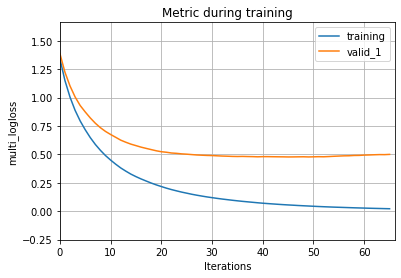

In [29]:
# Plot one metric during training.
ax = lgb.plot_metric(evals_result, metric='multi_logloss')  # multi_logloss指标绘制
plt.show()

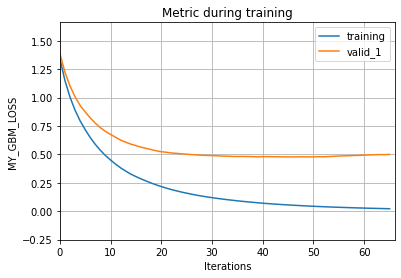

In [30]:
ax1 = lgb.plot_metric(evals_result, metric="MY_GBM_LOSS")  # MY_GBM_LOSS指标绘制
plt.show()

In [31]:
# 特征的相对重要性
model.feature_importance()

array([1648,  644,  389,  688,  677, 1476,  664,  557,  598, 1304,   99,
          0,   44,   60,   56,   17,    0,    0,   14,    0,    0,    0,
          0,   54,    0,   67,   50,    0,    0,    0,   25,    2,    0,
        187,    0,   12,   45,    8,    0,    0,    0,    0,   88,   98,
          1,    0,   11,    0,    0,    0,    0,    9,    1,    0])

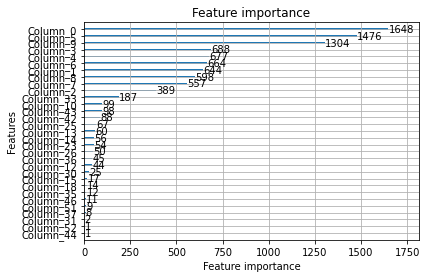

In [32]:
# 绘制特征的相对重要性
lgb.plot_importance(model)
plt.show()

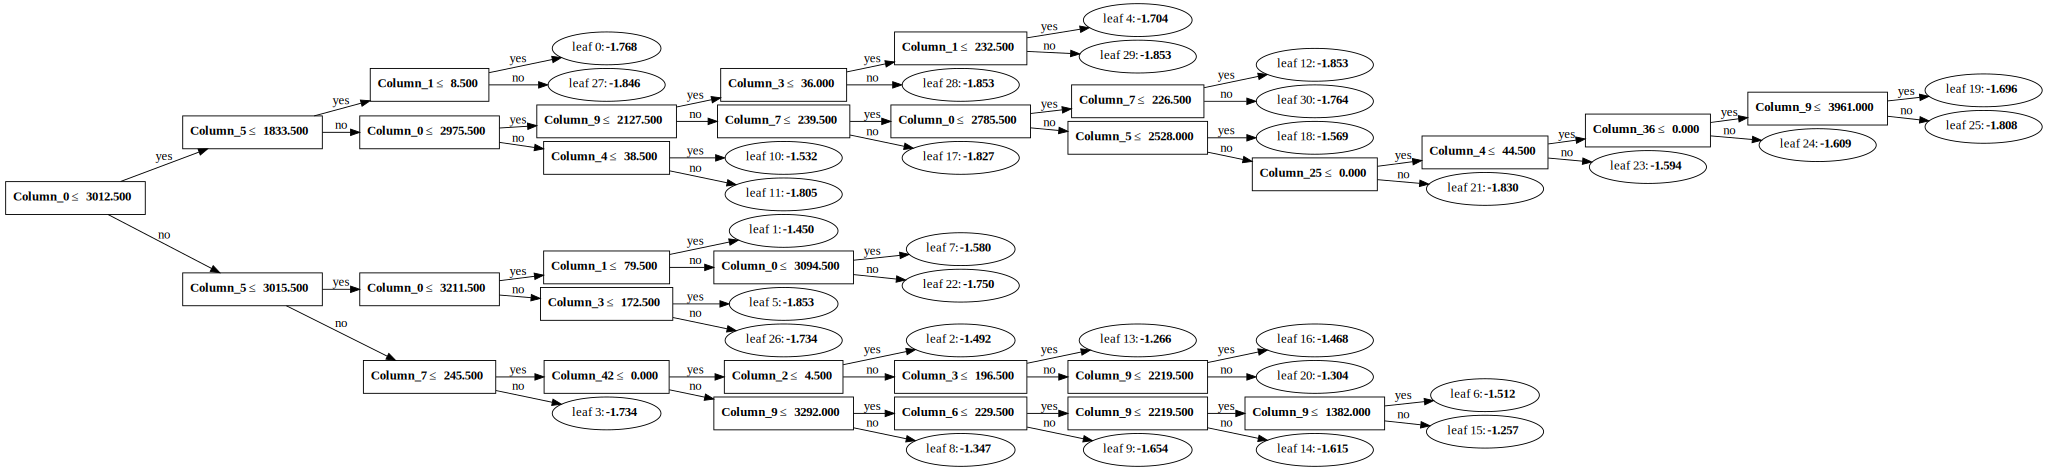

In [33]:
# 可视化lgb分割过程
img = lgb.create_tree_digraph(model)
img

In [34]:
# 数据类型为graphviz.dot.Digraph
type(img)

graphviz.dot.Digraph

In [35]:
# 图保存
# 可对img_view.gv中的数据进行解析
img.view(filename="img_view.gv")

'img_view.gv.pdf'